In [1]:
import numpy as np
import matplotlib.pyplot as plt

# $\star$ Question 1:
Load the points from regression.npz. 

Estimate the weight parameters using m<sup>th</sup> order polynomials as basis functions using the MLestimator. 

Numpy has various tools to invert matrices or to compute SVDs.

Plot the points together with the mean prediction. See how the outcome
changes as you change m.

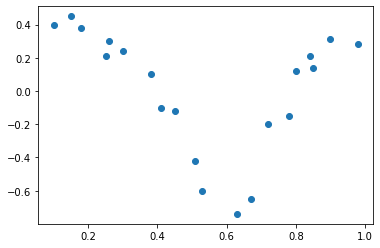

In [2]:
data = np.load('../data/regression.npz', mmap_mode='r')['arr_0']
data.shape
plt.scatter(data[:, 0], data[:, 1])
plt.show()

In [3]:
x = data[:, 0]
t = data[:, 1]
M = 20

def create_basis_functions(x, m):
    result = np.ones(x.shape)
    result = x
    i = 2
    while i <= m:
        result = np.vstack((result, x**i))
        i += 1
    return result.T    

X_basis = create_basis_functions(x, M)
X_basis.shape

(20, 20)

In [4]:
# Weight Estimation using ML
W = np.linalg.inv(X_basis.T @ X_basis) @ X_basis.T @ t
W.shape

(20,)

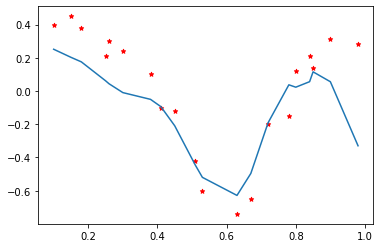

In [5]:
def plot_(W):
    y_pred = []
    x = data[data[:, 0].argsort()]
    X = x[:, 0]
    y = x[:, 1]
    for i in range(0, data.shape[0]):
        phi_x = create_basis_functions(X[i], M)
        y_pred.append(phi_x.dot(W))
    
    plt.plot(X, y_pred)
    plt.scatter(data[:, 0], data[:, 1], color='red', marker='*', s=20)

plot_(W)

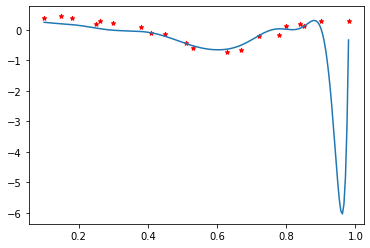

In [7]:
def plot_(W):
    x_test = np.linspace(min(data[:, 0]), max(data[:, 0]), 200)
    y_pred = []
    for i in range(0, 200):
        phi_x = create_basis_functions(x_test[i], M)
        y_pred.append(phi_x.dot(W)[0])
    
    plt.plot(x_test, y_pred)
    plt.scatter(data[:, 0], data[:, 1], color='red', marker='*', s=20)

plot_(W)
    

In [8]:
create_basis_functions(np.array([2]), 5).shape

(1, 5)

In [9]:
class Regressor:
    def __init__(self, M, x, t):
        self.M = M
        self.W = None
        self.x = x
        self.target = t
        self.basis_functions = None
        
        self.basis_functions = self.create_basis_functions(self.x)
        
    def create_basis_functions(self, x):
        basis = np.ones(x.shape)
        i = 1
        while i <= self.M:
            basis = np.vstack((basis, x**i))
            i += 1
        return basis.T
    
    def estimate_weights(self):
        self.W = np.linalg.inv(self.basis_functions.T @ self.basis_functions) @ self.basis_functions.T @ self.target
        self.var = (1 / self.x.shape[0]) * np.sum((self.target - self.basis_functions @ self.W) ** 2) 
    
    def predict(self, X):
        phi_x = self.create_basis_functions(X)
        return phi_x.dot(self.W)
    
    def plot_(self):
        x_test = np.linspace(min(data[:, 0]), max(data[:, 0]), 200)
        y_pred = []
        for i in range(0, 200):
            y_pred.append(self.predict(x_test[i]))
            
        fig, ax = plt.subplots()
        
        ax.plot(x_test, y_pred)        
        ax.scatter(self.x, self.target, color='red', marker='*', s=20)
        
        ax.set_ylim([-1, 1])
        ax.set_xlim([0, 1])
        ax.set_title("Plot for {} degree Polynomial, Variance: {}".format(self.M, np.round(self.var, 4)))

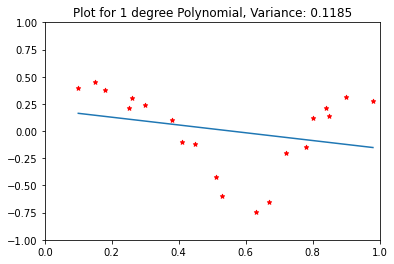

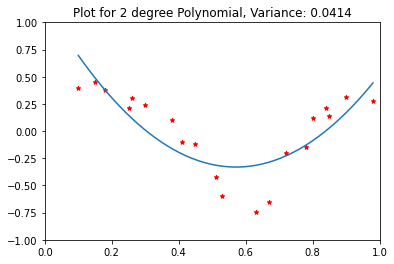

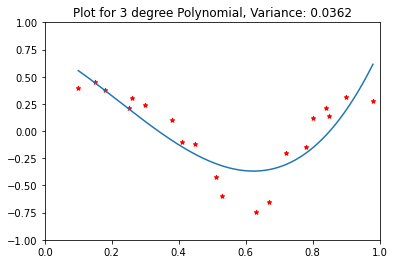

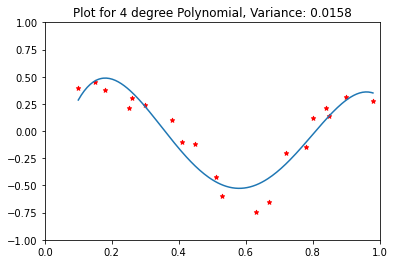

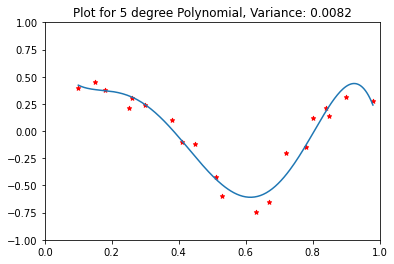

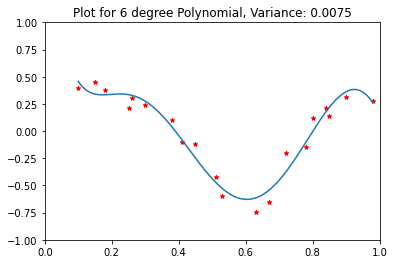

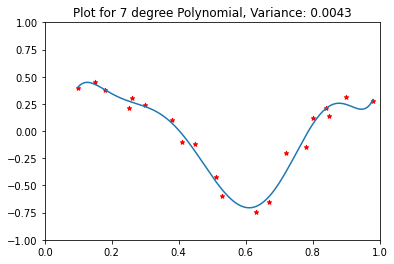

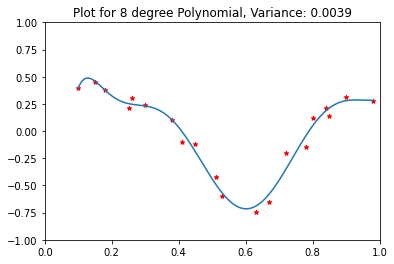

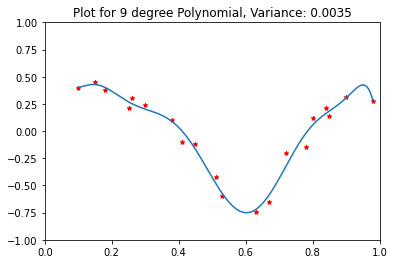

In [10]:
for i in range(1, 10):
    R = Regressor(i, data[:, 0], data[:, 1])
    R.estimate_weights()
    R.plot_()

# $\star$ Question 2:

Estimate the weights using the MAP estimator with the Gaussian prior
from this class (ridge regression).

Plot the points together with the mean prediction and the variance in the style of slide 14. 

See what happens as you use fewer and fewer points to estimate the weights.

Also see what happens as you change the hyperparameter and the order of the
polynomial m. When must be large, when can it be chosen smaller?

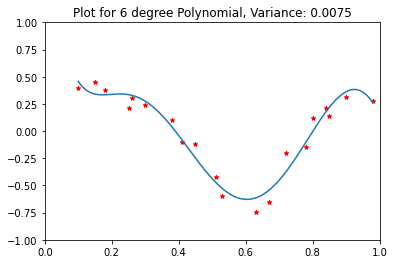

In [11]:
R = Regressor(6, data[:, 0], data[:, 1])
R.estimate_weights()
R.plot_()

In [12]:
# Use R.var as beta, estimate mean
beta = 1 / R.var
alpha = 0.01

class Regressor_MAP(Regressor):        
    def estimate_weights(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        basis_dim = self.basis_functions.shape[1]
        self.S_N_inv = np.linalg.inv(alpha * np.eye(basis_dim) + beta * self.basis_functions.T @ self.basis_functions)
        self.W = beta * (self.S_N_inv @ self.basis_functions.T @ self.target)
    
    def predict(self, X):
        phi_x = self.create_basis_functions(X)
        var = (1 / self.beta) * (phi_x @ self.S_N_inv @ phi_x.T)
        return phi_x.dot(self.W), var
    
    def plot_(self):
        fig, ax = plt.subplots(figsize=(8, 8))
        N = 500
        x_test = np.linspace(min(self.x), max(self.x), N)
        y_pred = []
        y_var = []
        for i in range(0, N):
            val, var = self.predict(x_test[i])
            y_pred.append(val)
            y_var.append(var)
            ax.scatter(x_test[i], val, color='lightblue', s=var*1000000)       
        ax.plot(x_test, y_pred, color='red')        
        
        ax.scatter(self.x, self.target, color='green')
        ax.set_ylim([-1, 1])
        ax.set_xlim([0, 1])
        ax.set_title("Plot for {} degree Polynomial".format(self.M))

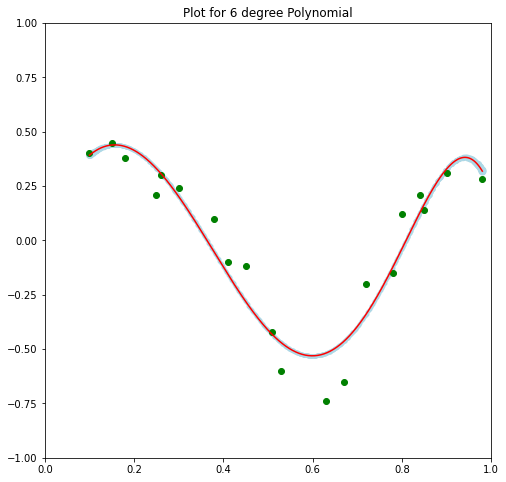

In [13]:
R_ = Regressor_MAP(M=6, x=data[0:20, 0], t=data[0:20, 1])
R_.estimate_weights(alpha=alpha, beta=beta)
R_.plot_()

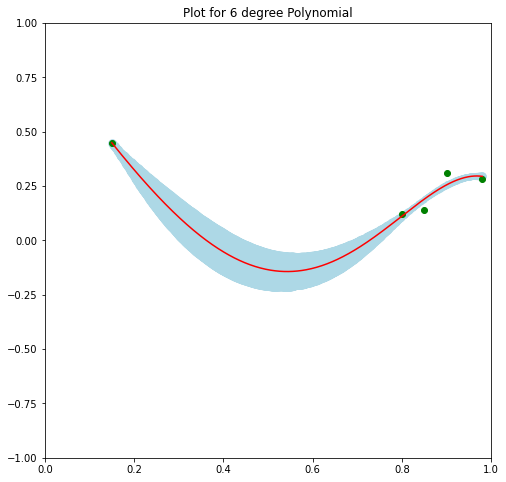

In [14]:
R_ = Regressor_MAP(M=6, x=data[0:5, 0], t=data[0:5, 1])
R_.estimate_weights(alpha=alpha, beta=beta)
R_.plot_()

# $\star \star \star$ Question 3:
Find the optimum hyperparameters using the evidence approximation. 
It is not that hard. You know EM and you know how to
estimate the weight parameters. Just combine these two. 

In [15]:
def create_basis_functions(x, m):
    result = np.ones(x.shape)
    i = 1
    while i <= m:
        result = np.vstack((result, x**i))
        i += 1
    return result.T    

def E_step(alpha, beta, M, X, t):
    phi_x = create_basis_functions(X, M)
    S_N_inv = np.linalg.inv(alpha * np.eye(M + 1) + beta * phi_x.T @ phi_x)
    W = beta * (S_N_inv @ phi_x.T @ t)
    
    return W, phi_x

def M_step(alpha, beta, W, phi_x):
    eig_values, _ = np.linalg.eig(beta * phi_x.T @ phi_x)
    temp = eig_values + alpha
    gamma = np.sum(eig_values / temp)
    
    alpha_ = gamma / np.sum(W[:, np.newaxis].T @ W[:, np.newaxis])
    N = phi_x.shape[0]
    var = np.sum((t - W.T @ phi_x.T) ** 2) / (N - gamma)
    beta_ = var**-1
    
    return alpha_, beta_

def evidence_approximation():
    alpha, beta, M, max_iter = 0.001, 1, 5, 100
#     X = data[data[:, 0].argsort()]  # sort for plotting
#     T = X[:, 1]
    X = data
    T = data[:, 1]
    
    for i in range(0, max_iter):
        W, phi_x = E_step(alpha, beta, M, X[:, 0], T)
        alpha_, beta_ = M_step(alpha, beta, W, phi_x)
        print("Alpha: {}, Beta: {}".format(alpha_, beta_))
        
        if abs(alpha - alpha_) < 1e-6 and abs(beta - beta_) < 1e-6: # Early Stopping
            break
        alpha, beta = alpha, beta_
        
    return W, alpha_, beta_

ev_W, ev_alpha, ev_beta = evidence_approximation()        

Alpha: 0.062320048292802535, Beta: 24.840346117178385
Alpha: 0.002022964059577264, Beta: 54.53983191619728
Alpha: 0.0014994664513255282, Beta: 59.50187764416568
Alpha: 0.0014591458028731788, Beta: 59.86159534911351
Alpha: 0.001456417289253841, Beta: 59.88561994260728
Alpha: 0.0014562359027526768, Beta: 59.88721557955994
Alpha: 0.0014562238593557085, Beta: 59.88732151756428
Alpha: 0.0014562230598046731, Beta: 59.88732855064148
Alpha: 0.0014562230066977031, Beta: 59.88732901775307
Alpha: 0.0014562230031439187, Beta: 59.88732904909786
Alpha: 0.0014562230029704119, Beta: 59.88732905060502
Alpha: 0.0014562230029187418, Beta: 59.88732905105292
Alpha: 0.0014562230029456196, Beta: 59.887329050894614
Alpha: 0.0014562230029030304, Beta: 59.88732905115613
Alpha: 0.0014562230029260546, Beta: 59.887329050983894
Alpha: 0.0014562230029125697, Beta: 59.88732905113994
Alpha: 0.0014562230029037798, Beta: 59.887329051091235
Alpha: 0.001456223002921095, Beta: 59.88732905099493
Alpha: 0.001456223002913598,